In [1]:
# a script for making pretty plots

In [2]:
# imports
import matplotlib.pyplot as plt
import numpy as np
import csv as csv

# general 
import os
import glob
from functools import reduce
import re

from sklearn import linear_model, datasets

from numpy import polyval

import pandas as pd

%matplotlib inline

In [3]:
# function for loading one data-set
def load_data(file_path):
    data = np.loadtxt(file_path, delimiter = '\t', skiprows=1)
    # print(data.shape) 
    # handles some weird cases, e.g. when there is no data in the file
    if (len(data.shape) < 2):
        data = data[None, :]
    if (data.shape[1] == 0):
        I = np.array([0])
        z = np.array([0])
    else:
        I = data[:, -1]
        z = data[:, -2]
    return (z, I)

In [4]:
# TODO: change the filepath and how it is constracted
# TODO: add the intensity values 

# function for loading one data-set
def load_data2(folder_path, idx, image, channel_id):
    # image = 'N2_dpy-23_ex_int_ama-1_015'
    path = folder_path + '/c' + str(channel_id) + "/"
    # file = 'N2_dpy-23_ex_int_ama-1_015.nd2 - N2_dpy-23_ex_int_ama-1_015.nd2 (series ' + str(idx).zfill(2) + ').tif.csv'
    file = image + '.nd2 - ' + image + '.nd2 (series ' + str(idx).zfill(2) + ') - C=' + str(channel_id - 1) + '.csv'
    
    print(file)
    
    data = np.loadtxt(path + file, delimiter = '\t')
    z = data[:, 3]
    I = data[:, 4]
    
    return (z, I)

In [5]:
# returns the y coordinate for the given line
# y = kx + b; also works with vectors
def f_x(x_, k_, b_):
    return k_*x_ + b_

In [6]:
def g_x(a, x):
    return polyval(a, x)

In [24]:
# general setup for pretty images 
num_files = 16
lines_params = np.zeros([num_files, 2])
channel_id = 1 # 1,2,3
# folder_path = '/Users/kkolyva/Desktop/2018-04-18-08-29-25-test/test/2018-04-24-15-33-21-median-median-first-test/csv/' 
image = 'N2_dpy-23_ex_int_ama-1_016'
Ia_min, Ia_max = 0, 40000
za_min, za_max = 0, 55

folder_path = '/Users/kkolyva/Desktop/2018-04-18-08-29-25-test/test/2018-05-08-11-57-09-median-median-first-test/'

In [25]:
# possible labels 
stain = ['DPY-23_EX', 'WDR-5.2', 'MDH-1']
stage = 'E' # only embryos
comment = '' # only empty ones

In [26]:
# important indices
stain_columns = ['C0_stain', 'C1_stain', 'C2_stain', 'C3_stain', 'C4_stain']
type_columns = ['C0_type', 'C1_type', 'C2_type', 'C3_type', 'C4_type']
stain_prefix = np.array([['C1-', 'C2-', 'C3-', 'C4-', 'C5-']])
ext = '.csv'
filename_column = 'new filename'

In [27]:
# read the db and parse images that we want to process
df = pd.read_csv(folder_path + "smFISH-database/N2-Table 1.csv", sep=',', na_values=['']);
df.head()

,Line,ID,C0_lambda,C0_stain,C0_type,C1_lambda,C1_stain,C1_type,C2_lambda,C2_stain,...,C4_lambda,C4_stain,C4_type,signal,Integrity,stage,comment,date,original filename,new filename
0,N2,1,670.0,FISH,DPY-23_EX,488.0,AF,NaN,405.0,NUCLEAR,...,NaN,NaN,NaN,3.0,0.0,L1,not complete,11/17/16,2016-11-17_N2-DPY-23-001.nd2,N2_1
1,N2,2,670.0,FISH,DPY-23_EX,488.0,AF,NaN,405.0,NUCLEAR,...,NaN,NaN,NaN,4.0,1.0,L1,dirt,11/17/16,2016-11-17_N2-DPY-23-002.nd2,N2_2
2,N2,3,670.0,FISH,DPY-23_EX,488.0,AF,NaN,405.0,NUCLEAR,...,NaN,NaN,NaN,2.0,0.0,L1,"dirt, not complete",11/17/16,2016-11-17_N2-DPY-23-003.nd2,N2_3
3,N2,4,670.0,FISH,DPY-23_EX,488.0,AF,NaN,405.0,NUCLEAR,...,NaN,NaN,NaN,4.0,1.0,L1,NaN,11/17/16,2016-11-17_N2-DPY-23-004.nd2,N2_4
4,N2,5,670.0,FISH,DPY-23_EX,488.0,AF,NaN,405.0,NUCLEAR,...,NaN,NaN,NaN,3.0,0.0,L1,not complete,11/17/16,2016-11-17_N2-DPY-23-005.nd2,N2_5


In [28]:
# this is general
# filter to have only *good* and *embryo* files
good_indices = np.logical_and((df['stage'] == stage).tolist() , (df['comment'].isnull()).tolist())
good_indices.shape[0]
print(np.sum(good_indices == True))

108


In [29]:
# choose necessary stains
dataset1 = []
df_good = (df[type_columns].astype(np.object) == stain[0]).loc[good_indices, :]
row, col = np.where(df_good)
n_samples = df.shape[0]
new_prefix = np.repeat(stain_prefix, n_samples, axis=0)[row, col]
new_filename = df[filename_column].loc[good_indices].as_matrix()[row]
dataset1 = ["{}{}".format(a_, b_) for a_, b_ in zip(new_prefix, new_filename)]

In [30]:
# choose necessary stains
dataset2 = []
df_good = (df[type_columns].astype(np.object) == stain[1]).loc[good_indices, :]
row, col = np.where(df_good)
n_samples = df.shape[0]
new_prefix = np.repeat(stain_prefix, n_samples, axis=0)[row, col]
new_filename = df[filename_column].loc[good_indices].as_matrix()[row]
dataset2 = ["{}{}".format(a_, b_) for a_, b_ in zip(new_prefix, new_filename)]

In [31]:
# choose necessary stains
dataset3 = []
df_good = (df[type_columns].astype(np.object) == stain[2]).loc[good_indices, :]
row, col = np.where(df_good)
n_samples = df.shape[0]
new_prefix = np.repeat(stain_prefix, n_samples, axis=0)[row, col]
new_filename = df[filename_column].loc[good_indices].as_matrix()[row]
dataset3 = ["{}{}".format(a_, b_) for a_, b_ in zip(new_prefix, new_filename)]

In [32]:
def create_title(path):
    # get the name of the initial image
    image_name = path.split("/")[8] # was 8
    # print(path.split("/"))
    # create the full title 
    title = image_name[:-4]
    return title
# create_title("/Users/kkolyva/Desktop/n2/N2-results/all/C1-N2_9.csv")

In [37]:
# actual plotting 
dataset = []
p_dataset = []
for j in range(0, len(dataset3)):
    tmp = folder_path + "csv/" + dataset3[j] + ".csv"
    # tmp = folder + N2_folder + "all/" + dataset1[j] + ".csv"
    dataset.append(tmp)
    # tmp = folder_path + "csv-parameters/" + dataset1[j] + ".csv"
    # p_dataset.append(tmp)
    print(tmp)

/Users/kkolyva/Desktop/2018-04-18-08-29-25-test/test/2018-05-08-11-57-09-median-median-first-test/csv/C2-N2_159.csv
/Users/kkolyva/Desktop/2018-04-18-08-29-25-test/test/2018-05-08-11-57-09-median-median-first-test/csv/C2-N2_167.csv
/Users/kkolyva/Desktop/2018-04-18-08-29-25-test/test/2018-05-08-11-57-09-median-median-first-test/csv/C2-N2_173.csv
/Users/kkolyva/Desktop/2018-04-18-08-29-25-test/test/2018-05-08-11-57-09-median-median-first-test/csv/C2-N2_174.csv
/Users/kkolyva/Desktop/2018-04-18-08-29-25-test/test/2018-05-08-11-57-09-median-median-first-test/csv/C2-N2_176.csv
/Users/kkolyva/Desktop/2018-04-18-08-29-25-test/test/2018-05-08-11-57-09-median-median-first-test/csv/C2-N2_182.csv
/Users/kkolyva/Desktop/2018-04-18-08-29-25-test/test/2018-05-08-11-57-09-median-median-first-test/csv/C2-N2_183.csv
/Users/kkolyva/Desktop/2018-04-18-08-29-25-test/test/2018-05-08-11-57-09-median-median-first-test/csv/C2-N2_184.csv
/Users/kkolyva/Desktop/2018-04-18-08-29-25-test/test/2018-05-08-11-57-09

In [38]:
# load the parameters from file for the fitter
def load_params(file_path):
    data = np.loadtxt(file_path, delimiter = '\t', skiprows=0)
    return data

In [39]:
labels = ['MDH-1'] # ['DPY-23_EX', 'WDR-5.2', 'MDH-1']

[]


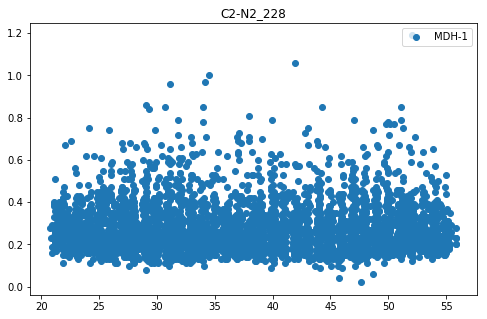

[]


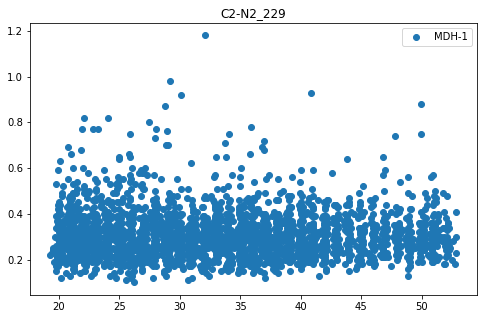

[]


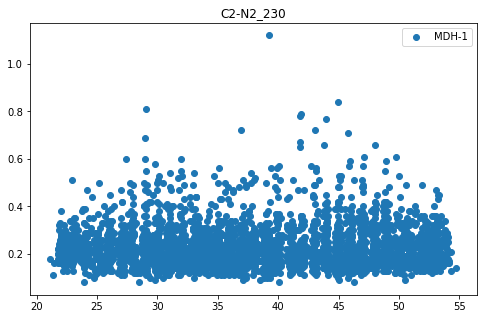

[]


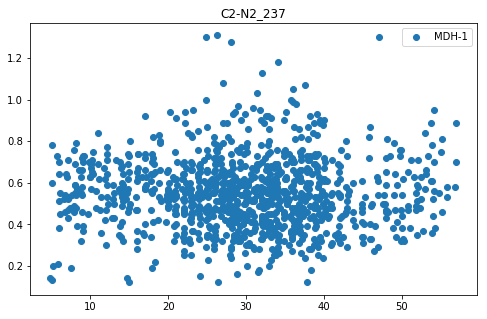

In [40]:
# actual plotting 
for idx in range(0, len(dataset)):
    # feedback
    
    if(not os.path.exists(dataset[idx])):
        # print("doesn't exist")
        continue
    
    # print("Processing:", dataset[idx]) 
    z,I = load_data(dataset[idx])
    
    # load the parameters from file
    # coeff = load_params(p_dataset[idx])
    
    print([])
    
    plt.figure(figsize=(8,5))
    
    title = create_title(dataset[idx])
    plt.title(title)

    plt.plot(z, I, 'o', label=labels[0])
    
    plt.legend(loc = 'upper right')
    plt.show()